In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = X_train.mean(axis=0) # mean on the number of training images
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return X_train - mean, X_val - mean, X_test - mean

X_train, X_val, X_test = prepro(X_train, X_val, X_test)

In [3]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        low, high = -1, 1
        
        # Input layer
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)

        # Hidden layers
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        
        # Output layer
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y = l.sigmoid(X=y)
#         y = np.exp(y) # func and dfunc are the same!
        X = y.copy() # pass to the next layer
        caches.append(fc_cache) # caches[0]
        
        # Hidden layers
        fc_caches = []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y = l.sigmoid(X=y)
#             y = np.exp(y) # func and dfunc are the same!
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
        caches.append(fc_caches) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
    
    def train_backward(self, dy, caches):
        grads = []

        # Input layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        
        # Hidden layer
        grad = []
        for layer in range(self.L):
            grad.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        grads.append(grad)

        # Outout layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy() # pass to the previous layer
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache = caches[0]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [4]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-100 train loss: 2.2858 valid loss: 2.3236, valid accuracy: 0.0924
Iter-200 train loss: 2.3640 valid loss: 2.3206, valid accuracy: 0.0924
Iter-300 train loss: 2.2929 valid loss: 2.3182, valid accuracy: 0.0920
Iter-400 train loss: 2.3380 valid loss: 2.3164, valid accuracy: 0.0792
Iter-500 train loss: 2.3258 valid loss: 2.3149, valid accuracy: 0.0406
Iter-600 train loss: 2.3200 valid loss: 2.3137, valid accuracy: 0.0364
Iter-700 train loss: 2.2933 valid loss: 2.3127, valid accuracy: 0.1040
Iter-800 train loss: 2.2967 valid loss: 2.3121, valid accuracy: 0.1126
Iter-900 train loss: 2.2720 valid loss: 2.3115, valid accuracy: 0.1126
Iter-1000 train loss: 2.2908 valid loss: 2.3113, valid accuracy: 0.1126
Iter-1100 train loss: 2.3004 valid loss: 2.3111, valid accuracy: 0.1126
Iter-1200 train loss: 2.3302 valid loss: 2.3109, valid accuracy: 0.1126
Iter-1300 train loss: 2.3036 valid loss: 2.3108, valid accuracy: 0.1126
Iter-1400 train loss: 2.3318 valid loss: 2.3108, valid accuracy: 0.1126
I

Iter-11500 train loss: 2.1752 valid loss: 2.1428, valid accuracy: 0.3118
Iter-11600 train loss: 2.1744 valid loss: 2.1381, valid accuracy: 0.3136
Iter-11700 train loss: 2.1566 valid loss: 2.1333, valid accuracy: 0.3186
Iter-11800 train loss: 2.0828 valid loss: 2.1284, valid accuracy: 0.3208
Iter-11900 train loss: 2.1152 valid loss: 2.1235, valid accuracy: 0.3224
Iter-12000 train loss: 2.1246 valid loss: 2.1185, valid accuracy: 0.3254
Iter-12100 train loss: 2.1097 valid loss: 2.1134, valid accuracy: 0.3290
Iter-12200 train loss: 2.1615 valid loss: 2.1084, valid accuracy: 0.3332
Iter-12300 train loss: 2.1441 valid loss: 2.1033, valid accuracy: 0.3342
Iter-12400 train loss: 2.1230 valid loss: 2.0982, valid accuracy: 0.3344
Iter-12500 train loss: 2.0796 valid loss: 2.0929, valid accuracy: 0.3394
Iter-12600 train loss: 2.0738 valid loss: 2.0878, valid accuracy: 0.3424
Iter-12700 train loss: 2.0996 valid loss: 2.0825, valid accuracy: 0.3446
Iter-12800 train loss: 2.0889 valid loss: 2.0773, v

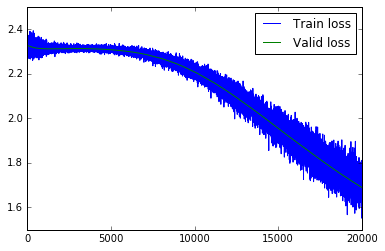

In [5]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

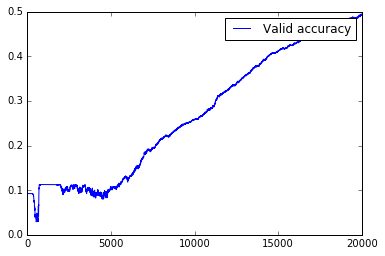

In [6]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()